In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import matplotlib.pyplot as plt


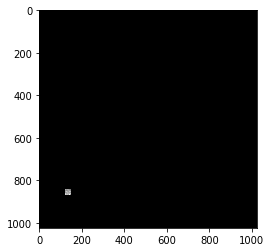

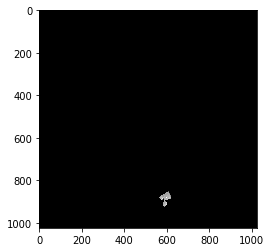

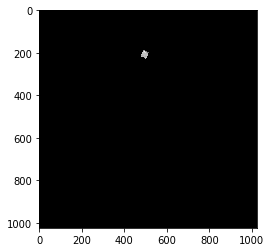

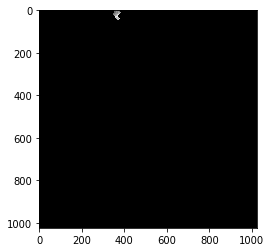

In [5]:
from os import listdir

# directory = ('/content/drive/My Drive/MaskImage')

directory = ('/content/drive/My Drive/maskedImage')

CATEGORIES=['destroyed','major-damage','minor-damage','no-damage']
for i in CATEGORIES:
    path=os.path.join(directory, i) # create path to category
    for img in os.listdir(path):  # iterate over each image per category
        img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) # convert to array
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break





In [6]:
print(img_array)
print(img_array.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1024, 1024)


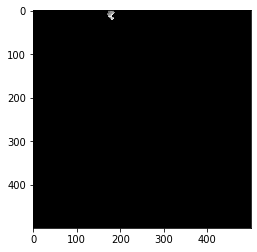

In [7]:
#resize the image(not need because all the image are the same size)
IMG_SIZE = 500
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap='gray')
plt.show()

In [8]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

IMG_SIZE = 500
training_data = []

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

def create_training_data():
    for i in CATEGORIES:  # do destroyed,major-damage,minor-damage,no-damage

        path = os.path.join(directory,i)  # create path to destroyed,major-damage,minor-damage,no-damage
        # print(path)
        class_num = CATEGORIES.index(i)  # get the classification  (0,1,2 0r a 3). 

        for img in tqdm(os.listdir(path)):  # iterate over each image per destroyed,major-damage,minor-damage,no-damage
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                # print(len(new_array))
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1110/1110 [10:34<00:00,  1.85it/s]

4420


In [9]:
#Our training_data is a list, meaning it's mutable, so it's now nicely shuffled. We can confirm this by iterating over 
#a few of the initial samples and printing out the class.
import random
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

2
0
1
2
1
0
2
2
2
0


[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]


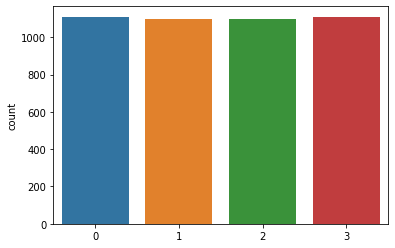

In [10]:
#Making our model
import seaborn as sns

X=[]
y=[]
for features, labels in training_data:
    X.append(features)
    y.append(labels)


print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)

# #Normalizing X from 0-255 to 0-1.
# X = X/255.0

sns.countplot(y)


In [11]:
#The basic CNN structure is as follows: Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected Layer -> Output

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model

#Normalizing X from 0-255 to 0-1.
X = X/255.0
input_s=(500,500,1)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same', activation='relu', input_shape=input_s))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

#define the second set of layers
model.add(Conv2D(64, kernel_size = (3, 3), padding='same', activation='relu', input_shape=input_s))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

# #define the third set of layers
model.add(Conv2D(96, kernel_size = (3, 3), padding='same', activation='relu', input_shape=input_s))
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


#The target variable of y is classify as three classes, we need to do the OneHot Encoding. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras import utils as np_utils

encoder=LabelEncoder()
encoder.fit(y)
encoded_y=encoder.transform(y)
y_code=np_utils.to_categorical(encoded_y)

import datetime
now = datetime.datetime.now
t = now()

X_train,X_test,y_train,y_test=train_test_split(X,y_code,test_size=0.3)
history = model.fit(X_train,y_train,
          batch_size=30,
          epochs=5,
          verbose=1,
          validation_data=(X_test,y_test))

score=model.evaluate(X_test,y_test,verbose=0)
print('Training time: %s' % (now() - t))

#acc is the accracy for the trian of the 3094 sample and 
#val_acc is the accuracy for the validation sample


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3094 samples, validate on 1326 samples
Epoch 1/5
3094/3094 [==============================] - 885s 286ms/sample - loss: 1.3877 - acc: 0.2469 - val_loss: 1.3865 - val_acc: 0.2489
Epoch 2/5
3094/3094 [==============================] - 867s 280ms/sample - loss: 1.3764 - acc: 0.3019 - val_loss: 1.3892 - val_acc: 0.2504
Epoch 3/5
3094/3094 [==============================] - 871s 281ms/sample - loss: 1.1488 - acc: 0.5126 - val_loss: 1.5356 - val_acc: 0.2489
Epoch 4/5
3094/3094 [==============================] - 872s 282ms/sample - loss: 0.5838 - acc: 0.7796 - val_loss: 2.8943 - val_acc: 0.2572
Epoch 5/5
3094/3094 [==============================] - 873s 282ms/sample - loss: 0.1682 - acc: 0.9415 - val_loss: 4.3022 - val_acc: 0.2526
Training time: 1:14:19.844164


In [12]:
#Our training_data is a list, meaning it's mutable, so it's now nicely shuffled. We can confirm this by iterating over 
#a few of the initial samples and printing out the class.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 96)      55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 369024)            0

In [13]:
X.shape

(4420, 500, 500, 1)

In [14]:
scores=model.evaluate(X_train,y_train)
print('\n%s:%.2f%%'%(model.metrics_names[1],scores[1]*100))

# evaluate the performance the new model and report the results
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3094/3094 [==============================] - 188s 61ms/sample - loss: 0.0530 - acc: 0.9842

acc:98.42%
Test Score: 4.302154866099178
Test Accuracy: 0.25263953


In [15]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test)
y_test_non=[np.argmax(t) for t in y_test]
y_pred_non=[np.argmax(t) for t in y_pred]

conf_mat=confusion_matrix(y_test_non, y_pred_non)
conf_mat

array([[73, 88, 84, 95],
       [77, 95, 91, 77],
       [64, 85, 78, 89],
       [68, 85, 88, 89]])

In [16]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print(classification_report(y_test_non,y_pred_non))

              precision    recall  f1-score   support

           0       0.26      0.21      0.23       340
           1       0.27      0.28      0.27       340
           2       0.23      0.25      0.24       316
           3       0.25      0.27      0.26       330

    accuracy                           0.25      1326
   macro avg       0.25      0.25      0.25      1326
weighted avg       0.25      0.25      0.25      1326



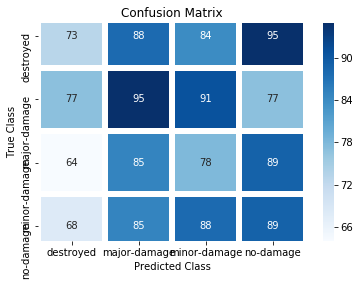

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt     

#Printing confusion matrix
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True,cmap='Blues',linewidths=5, linecolor='white',ax = ax); #annot=True to annotate cells
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.23, top - 0.2)

# labels, title and ticks
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['destroyed','major-damage','minor-damage','no-damage']); ax.yaxis.set_ticklabels(['destroyed','major-damage','minor-damage','no-damage']);

(3.73, 0.3)

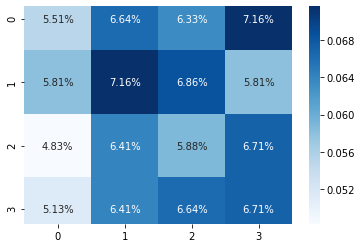

In [25]:
ax= plt.subplot()

sns.heatmap(conf_mat/np.sum(conf_mat), annot=True,
            fmt='.2%', cmap='Blues')
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.23, top - 0.2)

In [0]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

In [0]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

In [0]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(conf_mat,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, figsize=(10,15)):
    cm = confusion_matrix(y_test_non, y_pred_non, labels=np.unique(y_test_non))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test_non), columns=np.unique(y_pred_non))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
plot_cm(y_test_non, y_pred_non)

In [43]:
!pip -q install pygal

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import pygal
from IPython.display import display, HTML
from pygal.style import RedBlueStyle
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""
def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))
def plot_cm(y_test_non, y_pred_non):
    labels = np.unique(y_test_non)
    cm = confusion_matrix(y_test_non, y_pred_non, labels=labels)
    dot_chart = pygal.Dot(x_label_rotation=30, interpolate='cubic', style=RedBlueStyle)
    dot_chart.title = 'Confusion Matrix'
    dot_chart.x_labels = labels
    dot_chart.x_title = "Predicted"
    dot_chart.y_title = "Actual"
    for i in range(len(labels)):
        dot_chart.add(labels[i], cm[i,:])
    galplot(dot_chart)
plot_cm(y_test_non, y_pred_non)

In [0]:
make_confusion_matrix(conf_mat_3x3, figsize=(8,6), cbar=False)

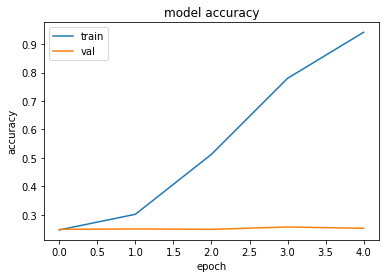

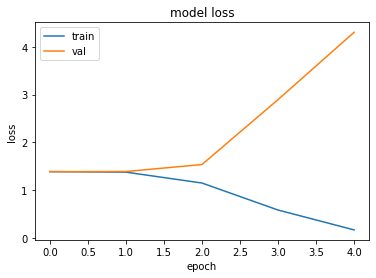

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()